Выбрала рандомный датасет с блюдами — пицца и не-пицца: https://www.kaggle.com/datasets/carlosrunner/pizza-not-pizza/data

In [1]:
!pip install torchvision torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 927.3/927.3 kB 16.1 MB/s eta 0:00:00


In [2]:
!pip install kaggle
import json
token = {"username":"ickthmp","key":"99dac009791178367e0dbf717b178652"}

with open('/content/kaggle.json', 'w') as file:
    json.dump(token, file)

!cp /content/kaggle.json ~/.kaggle/kaggle.json

!kaggle config set -n path -v{/content}

!chmod 600 /root/.kaggle/kaggle.json

!kaggle datasets download -d carlosrunner/pizza-not-pizza

!unzip \*.zip

cp: cannot create regular file '/root/.kaggle/kaggle.json': No such file or directory
Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python3.10/dist-packages/kaggle/__init__.py", line 7, in <module>
    api.authenticate()
  File "/usr/local/lib/python3.10/dist-packages/kaggle/api/kaggle_api_extended.py", line 407, in authenticate
    raise IOError('Could not find {}. Make sure it\'s located in'
OSError: Could not find kaggle.json. Make sure it's located in /root/.config/kaggle. Or use the environment method. See setup instructions at https://github.com/Kaggle/kaggle-api/
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Dataset URL: https://www.kaggle.com/datasets/carlosrunner/pizza-not-pizza
License(s): other
 96% 97.0M/101M [00:03<00:00, 39.8MB/s]
100% 101M/101M [00:03<00:00, 31.1MB/s] 
Archive:  pizza-not-pizza.zip
  inflating: pizza_not_pizza/food101_subset.py  


In [3]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as opt
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torchvision.transforms import Compose, Normalize, ToTensor
from sklearn.preprocessing import LabelEncoder
from torchmetrics import Accuracy as VAccuracy
from tqdm import tqdm
import random
from PIL import Image

In [4]:
def set_random_seed(seed):
    torch.backends.cudnn.deterministic = True
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

set_random_seed(42)

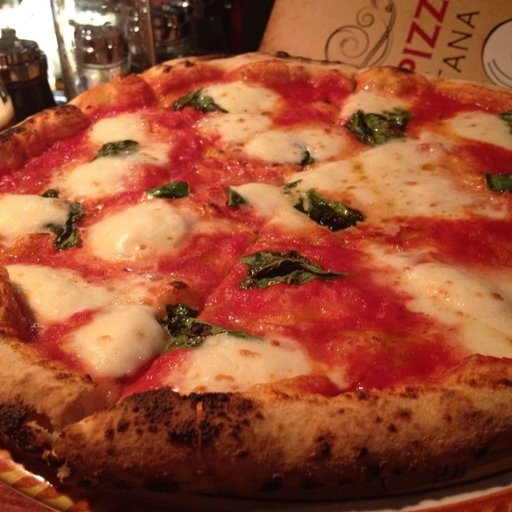

In [5]:
pizza = Image.open('pizza_not_pizza/pizza/1033251.jpg') # признайтесь, захотели...
pizza

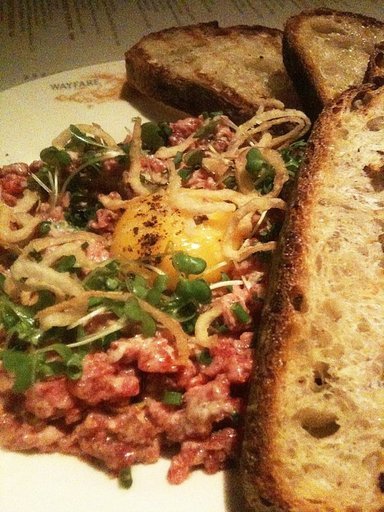

In [7]:
not_pizza = Image.open('pizza_not_pizza/not_pizza/315007.jpg') # тоже неплохо
not_pizza

In [15]:
pizza_img_count = len(os.listdir('pizza_not_pizza/pizza'))
not_pizza_img_count = len(os.listdir('pizza_not_pizza/not_pizza'))

print(f'Pizza images: {pizza_img_count}\nNot pizza images: {not_pizza_img_count}\nTotal images: {pizza_img_count + not_pizza_img_count}')

Pizza images: 983
Not pizza images: 983
Total images: 1966


#### Preprocessing

In [5]:
def estimate_mean_std(dataset) -> tuple[float]:
    '''Calculate channelwise mean and std for dataset'''

    channels_sum, channels_squared_sum, num_pixels = 0, 0, 0
    for sample, _ in dataset: # sample - картинка, _ - класс картинки
        sample = transforms.ToTensor()(sample)
        # channels_sum - сумма пикселей по каждому каналу (всего три канала)
        channels_sum += torch.sum(sample, dim=[1, 2]) # [3 x height x width] суммируем высоту и ширину
        channels_squared_sum += torch.sum(sample ** 2, dim=[1, 2])
        # число пикселей в картинке
        num_pixels += sample.size(1) * sample.size(2)

    mean = channels_sum / num_pixels

    std = (channels_squared_sum / num_pixels - mean ** 2) ** 0.5

    return mean, std

In [6]:
def preprocessing(dataset_path):

  # загружаем датасет для первичной обработки
  full_dataset = datasets.ImageFolder(dataset_path)

  # делим на train, val, test, чтобы потом на train и val оценить среднее и дисперсию
  train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [0.70, 0.15, 0.15], generator=torch.Generator().manual_seed(42))

  # объединяем тренировочную и валидационную выборки
  train_val_dataset = torch.utils.data.ConcatDataset([train_dataset, val_dataset])

  # нормализуем
  mean, std = estimate_mean_std(train_val_dataset)

  # превращаем в тензоры
  transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
    transforms.Resize((256, 256)) # приводим картинки к одному размеру
    ])

  # завново составляем датасет, уже с которым будем работать
  dataset = datasets.ImageFolder(dataset_path, transform=transform)

  train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [0.70, 0.15, 0.15], generator=torch.Generator().manual_seed(42))

  return mean, std, train_dataset, val_dataset, test_dataset

In [7]:
mean, std, train_dataset, val_dataset, test_dataset = preprocessing('pizza_not_pizza')

In [9]:
generator = set_random_seed(42)

In [10]:
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True, generator=generator)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=16, shuffle=False)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle=False)

#### Model

In [9]:
class PizzaCNN(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(3, 10, kernel_size=5) # 3 канала, 10 ядер, размер ядра - 5
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.pool = nn.MaxPool2d(2) # макс-пулинг: уменьшим на 2
        self.flatten = nn.Flatten()

        self.fc1 = nn.Linear(124 * 124 * 20, 128) # слой на 128 нейронов
        self.fc2 = nn.Linear(128, 2)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [11]:
def train_loop(model, optimizer, n_epochs):
    for epoch in range(1, n_epochs + 1):

        for x_train, y_train in tqdm(train_dataloader): # train
            y_pred = model(x_train)
            loss = F.cross_entropy(y_pred, y_train)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()


        if epoch % 2 == 0: # validation
            val_loss = []
            val_accuracy = []
            with torch.no_grad():
                for x_val, y_val in tqdm(val_dataloader):
                    y_pred = model(x_val)
                    loss = F.cross_entropy(y_pred, y_val)
                    val_loss.append(loss.numpy())
                    val_accuracy.extend((torch.argmax(y_pred, dim=-1) == y_val).numpy().tolist())

            print(f"Epoch: {epoch}\tloss: {np.mean(val_loss)}\taccuracy: {np.mean(val_accuracy)}")

In [14]:
model = PizzaCNN()
optimizer = opt.Adam(model.parameters(), lr=0.001)

In [15]:
train_loop(model, optimizer, 10)

100%|██████████| 19/19 [00:14<00:00,  1.27it/s]


Epoch: 2	loss: 0.555334746837616	accuracy: 0.6779661016949152


100%|██████████| 19/19 [00:14<00:00,  1.30it/s]


Epoch: 4	loss: 0.5691232681274414	accuracy: 0.735593220338983


100%|██████████| 19/19 [00:14<00:00,  1.29it/s]


Epoch: 6	loss: 1.0397143363952637	accuracy: 0.6779661016949152


100%|██████████| 19/19 [00:14<00:00,  1.32it/s]


Epoch: 8	loss: 1.3076566457748413	accuracy: 0.6847457627118644


100%|██████████| 19/19 [00:15<00:00,  1.26it/s]

Epoch: 10	loss: 1.4168052673339844	accuracy: 0.688135593220339


In [15]:
from sklearn.metrics import classification_report

In [16]:
def classification_metrics(model, dataloader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for x_test, y_test in tqdm(dataloader):
            y_pred = model(x_test)
            y_pred_classes = torch.argmax(y_pred, dim=-1)
            all_preds.extend(y_pred_classes.cpu().numpy())
            all_labels.extend(y_test.cpu().numpy())

    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    test_accuracy = np.mean(all_preds == all_labels)

    print(classification_report(all_labels, all_preds))
    print(f"Test accuracy: {test_accuracy:.4%}")

In [37]:
classification_metrics(model, test_dataloader)

100%|██████████| 19/19 [00:14<00:00,  1.31it/s]

              precision    recall  f1-score   support

           0       0.72      0.58      0.64       159
           1       0.60      0.73      0.66       135

    accuracy                           0.65       294
   macro avg       0.66      0.66      0.65       294
weighted avg       0.66      0.65      0.65       294

Test accuracy: 64.9660%


Угадали больше половины (хотелось бы побольше, конечно). Попробую задать всего 5 эпох:

In [38]:
train_loop(model, optimizer, 5)

100%|██████████| 19/19 [00:14<00:00,  1.31it/s]


Epoch: 2	loss: 1.5316871404647827	accuracy: 0.6847457627118644


100%|██████████| 19/19 [00:14<00:00,  1.32it/s]


Epoch: 4	loss: 1.5834487676620483	accuracy: 0.6847457627118644


100%|██████████| 87/87 [03:54<00:00,  2.70s/it]


In [39]:
classification_metrics(model, test_dataloader)

100%|██████████| 19/19 [00:14<00:00,  1.33it/s]

              precision    recall  f1-score   support

           0       0.71      0.60      0.65       159
           1       0.60      0.72      0.66       135

    accuracy                           0.65       294
   macro avg       0.66      0.66      0.65       294
weighted avg       0.66      0.65      0.65       294

Test accuracy: 65.3061%


In [21]:
def matplotlib_imshow(img, one_channel=False):
    """A function for plotting unnormalized images, but it still gets clipping warning"""
    if one_channel:
        img = img.mean(dim=0)
    img = img * std + mean
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (0, 1, 2)))

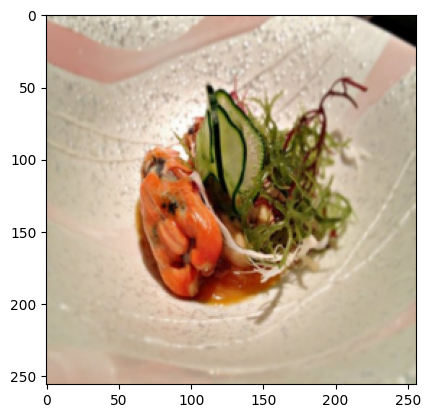

This is Not pizza
PizzaCNN thinks it is Not pizza


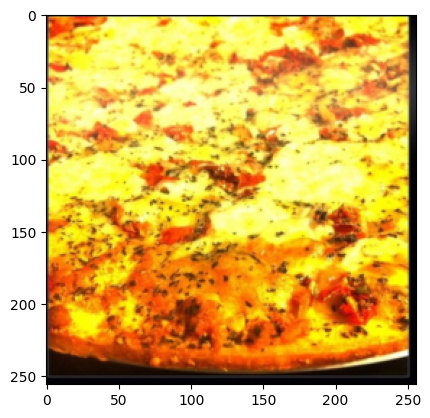

This is Pizza
PizzaCNN thinks it is Pizza


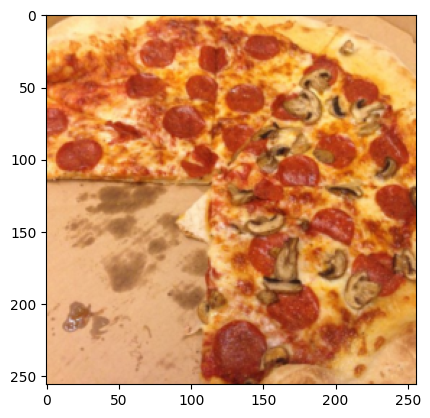

This is Pizza
PizzaCNN thinks it is Pizza


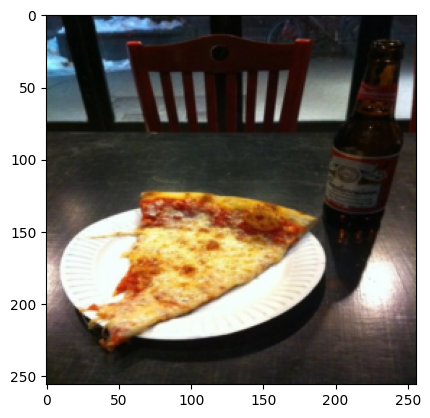

This is Pizza
PizzaCNN thinks it is Pizza


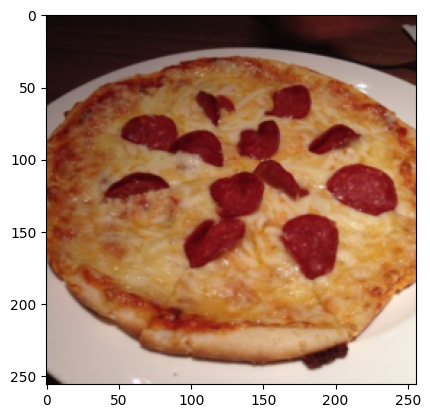

This is Pizza
PizzaCNN thinks it is Pizza


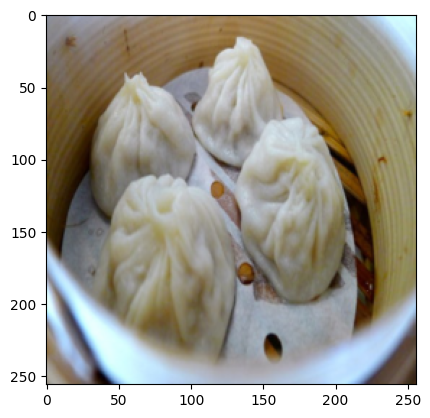

This is Not pizza
PizzaCNN thinks it is Pizza


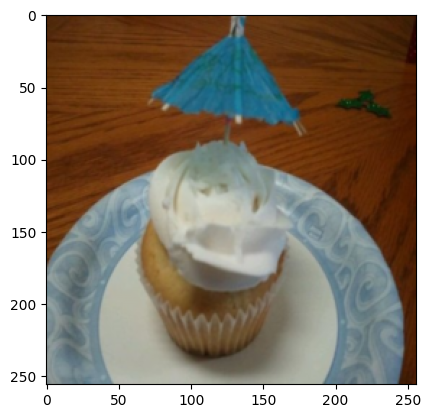

This is Not pizza
PizzaCNN thinks it is Not pizza


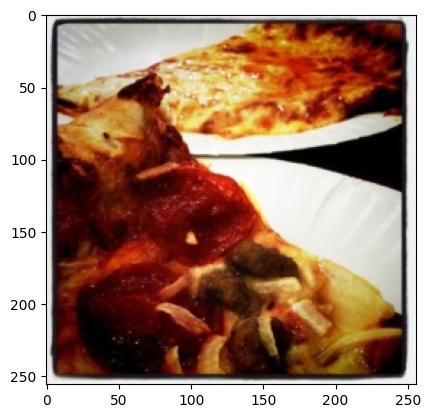

This is Pizza
PizzaCNN thinks it is Not pizza


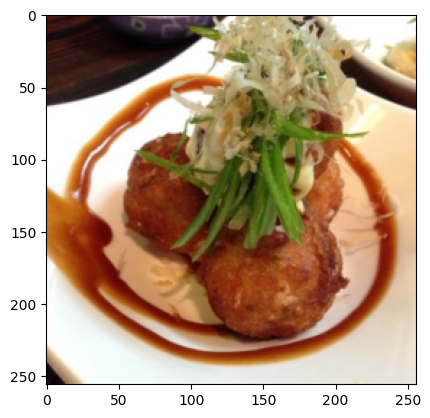

This is Not pizza
PizzaCNN thinks it is Not pizza


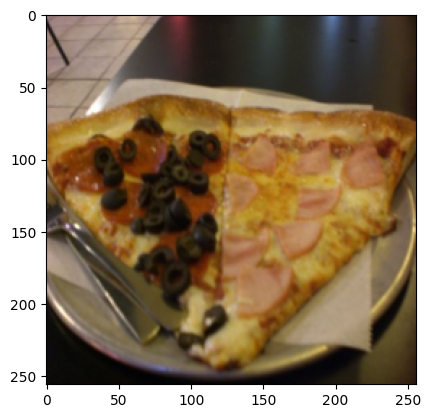

This is Pizza
PizzaCNN thinks it is Not pizza


In [24]:
classes = {0: 'Not pizza', 1: 'Pizza'}

model.eval()

for i in range(10):
    img, label = test_dataset[i]
    matplotlib_imshow(img.permute(1, 2, 0))
    plt.show()
    print(f"This is {classes[label]}")
    ypred = model(img.unsqueeze(0)) # добавляет еще размер
    print(f"PizzaCNN thinks it is {classes[torch.argmax(ypred, dim=-1).item()]}")

Поэкспериментирую с архитектурой:

In [12]:
class PizzaCNN(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1) # размер ядра 5 --> 3 + увеличили кол-во слоев + добавили паддинг
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2)
        # self.flatten = nn.Flatten()

        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))

        self.fc1 = nn.Linear(128, 128) # слой на 128 нейронов
        self.fc2 = nn.Linear(128, 2)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        x = self.pool(x)
        x = self.global_pool(x)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [13]:
model2 = PizzaCNN()
optimizer = opt.Adam(model2.parameters(), lr=0.001)

In [14]:
train_loop(model2, optimizer, 5)

100%|██████████| 19/19 [00:30<00:00,  1.62s/it]


Epoch: 2	loss: 0.568708598613739	accuracy: 0.6813559322033899


100%|██████████| 19/19 [00:30<00:00,  1.59s/it]


Epoch: 4	loss: 0.5574793815612793	accuracy: 0.688135593220339


100%|██████████| 87/87 [04:44<00:00,  3.26s/it]


In [17]:
classification_metrics(model2, test_dataloader)

100%|██████████| 19/19 [00:29<00:00,  1.54s/it]

              precision    recall  f1-score   support

           0       0.79      0.73      0.76       159
           1       0.71      0.78      0.74       135

    accuracy                           0.75       294
   macro avg       0.75      0.75      0.75       294
weighted avg       0.76      0.75      0.75       294

Test accuracy: 75.1701%


Уже лучше!

Покрутим еще что-нибудь: добавила нормализацию батчей после каждый свертки и дропаут после fc1

In [28]:
class PizzaCNN(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool = nn.MaxPool2d(2)

        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))

        self.fc1 = nn.Linear(128, 128)
        self.dropout = nn.Dropout(0.3)
        self.fc2 = nn.Linear(128, 2)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool(x)

        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)

        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool(x)

        x = self.global_pool(x)

        x = torch.flatten(x, 1) # из тензора в вектор
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [29]:
model3 = PizzaCNN()
optimizer = opt.Adam(model3.parameters(), lr=0.001)

In [30]:
train_loop(model3, optimizer, 5)

100%|██████████| 19/19 [00:33<00:00,  1.79s/it]


Epoch: 2	loss: 0.506316602230072	accuracy: 0.7491525423728813


100%|██████████| 19/19 [00:34<00:00,  1.81s/it]


Epoch: 4	loss: 0.5331034660339355	accuracy: 0.7186440677966102


100%|██████████| 87/87 [05:20<00:00,  3.69s/it]


In [31]:
classification_metrics(model3, test_dataloader)

100%|██████████| 19/19 [00:30<00:00,  1.60s/it]

              precision    recall  f1-score   support

           0       0.81      0.68      0.74       159
           1       0.68      0.81      0.74       135

    accuracy                           0.74       294
   macro avg       0.74      0.74      0.74       294
weighted avg       0.75      0.74      0.74       294

Test accuracy: 73.8095%


Стало немного хуже... (потом я попробовала с leaky_relu, и всё стало еще хуже)